## Загрузка библиотек

In [34]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import seaborn as sns

import zipfile
import os
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [35]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Загрузка данных

In [37]:
kaggle_path = '/content/drive/MyDrive/MFTI/SEM_02/Deep_learning/kaggle.json'
!mkdir -p ~/.kaggle
!cp "{kaggle_path}" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [38]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


## Распаковка датасета

In [ ]:
with zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/chest-xray-pneumonia')

for root, dirs, files in os.walk('/content/chest-xray-pneumonia'):
    for name in files:
        print(os.path.join(root, name))

In [40]:
data_dir = '/content/chest-xray-pneumonia/chest_xray'
for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(data_dir, split, cls)
        print(f"{folder}: {len(os.listdir(folder))} images")

/content/chest-xray-pneumonia/chest_xray/train/NORMAL: 1341 images
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA: 3875 images
/content/chest-xray-pneumonia/chest_xray/val/NORMAL: 8 images
/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA: 8 images
/content/chest-xray-pneumonia/chest_xray/test/NORMAL: 234 images
/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA: 390 images


In [41]:
!ls /content/chest-xray-pneumonia/chest_xray
!ls /content/chest-xray-pneumonia/chest_xray/train
!ls /content/chest-xray-pneumonia/chest_xray/train/NORMAL | head

chest_xray  __MACOSX  test  train  train_subset  val
NORMAL	PNEUMONIA
IM-0115-0001.jpeg
IM-0117-0001.jpeg
IM-0119-0001.jpeg
IM-0122-0001.jpeg
IM-0125-0001.jpeg
IM-0127-0001.jpeg
IM-0128-0001.jpeg
IM-0129-0001.jpeg
IM-0131-0001.jpeg
IM-0133-0001.jpeg


## Проверка данных

### Визуализация изображений

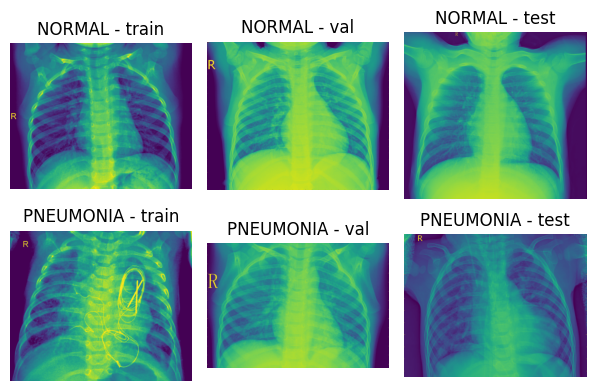

In [42]:
plt.figure(figsize=(10, 6))
for i, cls in enumerate(['NORMAL', 'PNEUMONIA']):
    for j, split in enumerate(['train', 'val', 'test']):
        images_path = os.listdir(os.path.join(data_dir, split, cls))
        img_path = random.choice(images_path)
        img = Image.open(os.path.join(data_dir, split, cls, img_path))
        plt.subplot(3, 5, i * 5 + j + 1)
        plt.imshow(img)
        plt.title(f'{cls} - {split}')
        plt.axis('off')
plt.tight_layout()
plt.show()

### Проверка на дисбаланс классов в обучающей выборке

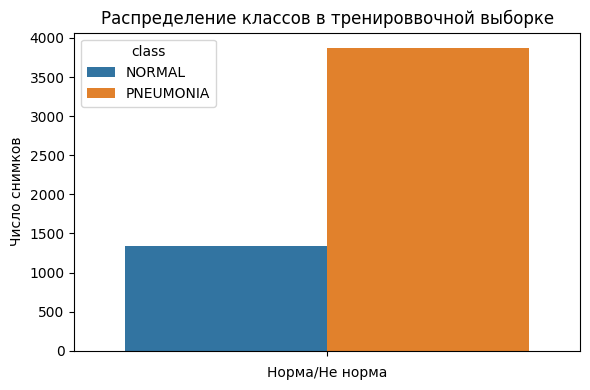

In [43]:
base_dir = '/content/chest-xray-pneumonia/chest_xray/train'
classes = ['NORMAL', 'PNEUMONIA']

data = []

for cls in classes:
    folder = os.path.join(base_dir, cls)
    count = len(os.listdir(folder))
    data.append({'class': cls, 'count': count})

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))
sns.barplot(y='count', hue='class', data=df)
plt.title('Распределение классов в тренироввочной выборке')
plt.ylabel('Число снимков')
plt.xlabel('Норма/Не норма')
plt.tight_layout()
plt.show()

В обучающей выборке наблюдается дисбаланс классов -> `PNEUMONIA: 3875, NORMAL: 1341`. Это может привести к смещению модели в сторону преобладающего класса. В зависомости от того как покажет себя модель возможно использование `class_weight` при обучении для учета этого дисбаланса.

### Проверка размеров изображений и формата каналов

In [44]:
paths = []
for cls in classes:
    folder = os.path.join(base_dir, cls)
    paths += [os.path.join(folder, fname) for fname in os.listdir(folder)]

sample_paths = random.sample(paths, 10)
for p in sample_paths:
    img = Image.open(p)
    print(f"{p}: {img.size}, mode: {img.mode}")

/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1108-0001.jpeg: (1620, 1310), mode: L
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person23_bacteria_100.jpeg: (984, 648), mode: L
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person993_bacteria_2921.jpeg: (1184, 792), mode: L
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1496_bacteria_3909.jpeg: (1296, 1000), mode: L
/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0466-0001.jpeg: (1600, 1264), mode: L
/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1161-0001.jpeg: (1600, 1380), mode: L
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person656_bacteria_2548.jpeg: (1144, 592), mode: L
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person541_virus_1071.jpeg: (1344, 856), mode: L
/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person466_bacteria_1984.jpeg: (650, 378), mode: RGB
/content/chest-xray-pneumonia/chest_xray/train/PNEUMON

In [45]:
modes_count = {'L': 0, 'RGB': 0, 'other': 0}

for cls in classes:
   folder = os.path.join(base_dir, cls)
   for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpeg', '.jpg', '.png')):
            fpath = os.path.join(folder, fname)
            try:
                with Image.open(fpath) as img:
                    if img.mode == 'L':
                        modes_count['L'] += 1
                    elif img.mode == 'RGB':
                        modes_count['RGB'] += 1
                    else:
                        modes_count['other'] += 1
            except Exception as e:
                pass

print(f"Grayscale ('L'): {modes_count['L']}")
print(f"RGB: {modes_count['RGB']}")
print(f"Other modes: {modes_count['other']}")

Grayscale ('L'): 4933
RGB: 283
Other modes: 0


In [46]:
shapes = []
for p in paths:
    img = Image.open(p)
    shapes.append(img.size)
sizes = pd.DataFrame(shapes, columns=['width', 'height'])
print(sizes.describe())

             width       height
count  5216.000000  5216.000000
mean   1320.610813   968.074770
std     355.298743   378.855691
min     384.000000   127.000000
25%    1056.000000   688.000000
50%    1284.000000   888.000000
75%    1552.000000  1187.750000
max    2916.000000  2663.000000


Изображения читаются без ошибок, основной массив имеет формат `grayscale`, иногда встречаются `RGB`, размеры изобраений будут приведены к единому на этапе процессинга

## Подготовка изображений для обучения

In [49]:
train_datagen = ImageDataGenerator(
    rescale=1./127.5 - 1,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./127.5 - 1)

train_gen = train_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True,
)

val_gen = val_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False,
)

test_gen = val_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False,
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Для обучения модели были созданы три генератора: для `train`, `validation` и `test` выборок. В обучающем генераторе использованы аугментации (повороты, сдвиги, масштабирование, отражение) и нормализация изображений в диапазон
`-1;1`.

Для `validation` и `test-генераторов` применялась только нормализация,аугментации не использовались для чистоты оценки. Все изображения были приведены к размеру `224 x 224` пикселя и трёхканальному формату RGB. Это обеспечивает единообразие входных данных и корректную работу современных сверточных нейросетей.

## Базовая модель

In [50]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,569 (396.75 KB)

 Trainable params: 101,569 (396.75 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

### Обучение базовой модели

In [52]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stop],
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 590ms/step - accuracy: 0.6856 - auc: 0.5436 - loss: 1.7096 - precision: 0.7461 - recall: 0.8730 - val_accuracy: 0.7500 - val_auc: 0.9062 - val_loss: 0.4976 - val_precision: 0.7000 - val_recall: 0.8750
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.8125 - auc: 0.8707 - loss: 0.3839 - precision: 0.8536 - recall: 0.9054 - val_accuracy: 0.6875 - val_auc: 0.8906 - val_loss: 0.4940 - val_precision: 0.6667 - val_recall: 0.7500
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 592ms/step - accuracy: 0.8542 - auc: 0.9147 - loss: 0.3321 - precision: 0.9174 - recall: 0.8830 - val_accuracy: 0.7500 - val_auc: 0.9219 - val_loss: 0.6158 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 597ms/step - accuracy: 0.8759 - auc: 0.9318 - loss: 0.2868 - precision: 0.9316 - recall: 0.9011 - val_accuracy: 0.6875 - val_auc: 0.8906 - val_loss: 1.2272 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 5/15
163/163 

### Оценим метрики базовой модели на тесте

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step
              precision    recall  f1-score   support

      NORMAL       0.66      0.90      0.76       234
   PNEUMONIA       0.92      0.72      0.81       390

    accuracy                           0.79       624
   macro avg       0.79      0.81      0.79       624
weighted avg       0.82      0.79      0.79       624

F1-score: 0.8103


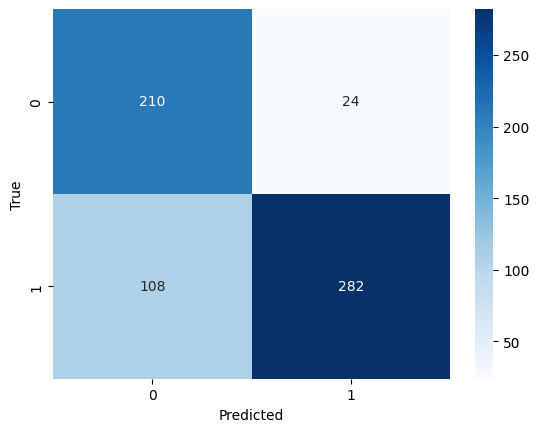

In [53]:
y_pred_proba = model.predict(test_gen)
y_pred = (y_pred_proba > 0.5).astype(int).reshape(-1)

y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

f1 = f1_score(y_true, y_pred)
print(f'F1-score: {f1:.4f}')

cm = confusion_matrix(y_true, y_pred)
scm = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ROC-AUC: 0.8711


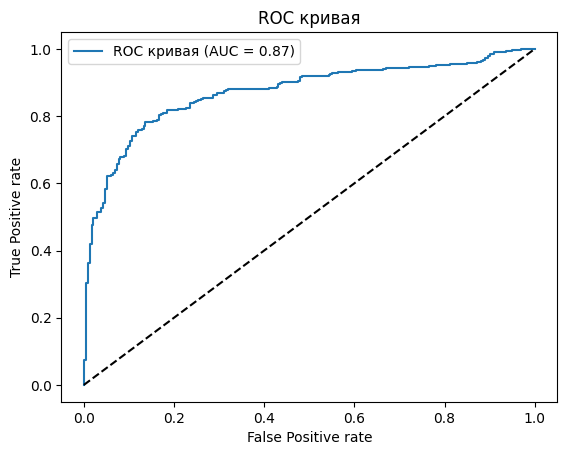

In [54]:
roc_auc = roc_auc_score(y_true, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC кривая (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC кривая")
plt.legend()
plt.show()

## Улучшенная модель

In [55]:
# загрузка базовой MobileNetV2 без верхушки
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# своя голова для классификации
model_tl = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model_tl.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

model_tl.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_tl = model_tl.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stop],
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 613ms/step - accuracy: 0.8590 - auc: 0.9043 - loss: 0.3087 - precision: 0.8998 - recall: 0.9155 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.3044 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 586ms/step - accuracy: 0.9454 - auc: 0.9821 - loss: 0.1468 - precision: 0.9629 - recall: 0.9632 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2870 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9517 - auc: 0.9864 - loss: 0.1273 - precision: 0.9674 - recall: 0.9682 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2476 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.9469 - auc: 0.9856 - loss: 0.1317 - precision: 0.9626 - recall: 0.9650 - val_accuracy: 0.9375 - val_auc: 1.0000 - val_loss: 0.2097 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 5/15
163/163 

In [57]:
# для улучшения метрики, разморозим несколько слоев для дообучения
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# снова дообучим но у же с меньшим learning_rate
model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

history_ft = model_tl.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[early_stop]
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 610ms/step - accuracy: 0.8884 - auc: 0.9355 - loss: 0.3010 - precision: 0.9237 - recall: 0.9281 - val_accuracy: 0.6875 - val_auc: 1.0000 - val_loss: 0.8946 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 587ms/step - accuracy: 0.9322 - auc: 0.9762 - loss: 0.1796 - precision: 0.9579 - recall: 0.9506 - val_accuracy: 0.6875 - val_auc: 1.0000 - val_loss: 0.7955 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 588ms/step - accuracy: 0.9475 - auc: 0.9853 - loss: 0.1363 - precision: 0.9667 - recall: 0.9622 - val_accuracy: 0.7500 - val_auc: 1.0000 - val_loss: 0.4704 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 585ms/step - accuracy: 0.9483 - auc: 0.9832 - loss: 0.1409 - precision: 0.9639 - recall: 0.9666 - val_accuracy: 0.6875 - val_auc: 1.0000 - val_loss: 0.6380 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 5/15
163/163 

### Оценим метрики улучшенной модели на тесте

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 369ms/step
              precision    recall  f1-score   support

      NORMAL       0.89      0.68      0.77       234
   PNEUMONIA       0.83      0.95      0.89       390

    accuracy                           0.85       624
   macro avg       0.86      0.81      0.83       624
weighted avg       0.85      0.85      0.84       624

F1-score: 0.8862


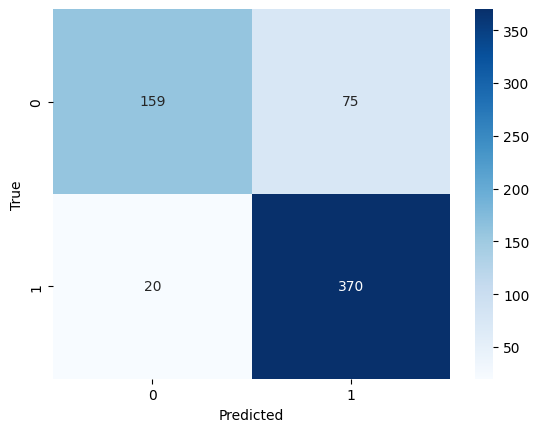

In [58]:
y_pred_proba_tl = model_tl.predict(test_gen)
y_pred_tl = (y_pred_proba_tl > 0.5).astype(int).reshape(-1)

y_true = test_gen.classes

print(classification_report(y_true, y_pred_tl, target_names=['NORMAL', 'PNEUMONIA']))

f1_tl = f1_score(y_true, y_pred_tl)
print(f'F1-score: {f1_tl:.4f}')

cm = confusion_matrix(y_true, y_pred_tl)
scm = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ROC-AUC: 0.9437


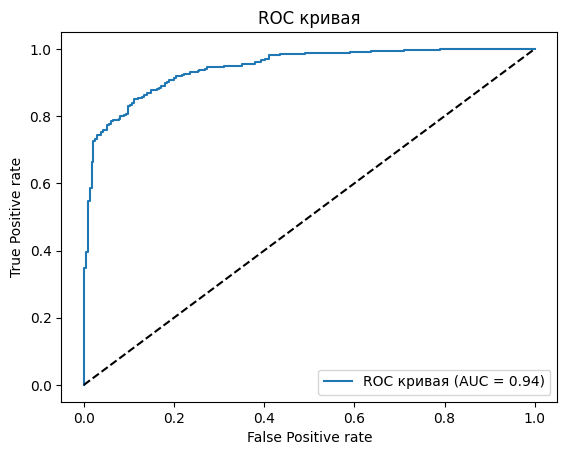

In [59]:
roc_auc_tl = roc_auc_score(y_true, y_pred_proba_tl)
print(f"ROC-AUC: {roc_auc_tl:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_pred_proba_tl)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC кривая (AUC = {roc_auc_tl:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC кривая")
plt.legend()
plt.show()

## Сравнение метрик

In [60]:
metrics = {
    "Model": ["Baseline CNN", "Transfer Learning"],
    "F1-score": [f1, f1_tl],
    "ROC-AUC": [roc_auc, roc_auc_tl]
}

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

improvement = (roc_auc_tl - roc_auc) / roc_auc * 100
print(f"Улучшение ROC-AUC: {improvement:.2f}%")
if improvement >= 5:
    print("Улучшение ≥ 5% — требование задания выполнено!")
else:
    print("Улучшение менее 5%.")

,Model,F1-score,ROC-AUC
0,Baseline CNN,0.810345,0.871126
1,Transfer Learning,0.886228,0.943743


Улучшение ROC-AUC: 8.34%
Улучшение ≥ 5% — требование задания выполнено!


## Выводы по результатам обучения двух моделей

В таблице ниже приведены значения основных метрик (F1-score, ROC-AUC) для базовой сверточной нейросети и transfer learning на базе MobileNetV2:

| Model             | F1-score | ROC-AUC |
|-------------------|----------|---------|
| Baseline CNN      | 0.810345 | 0.871126 |
| Transfer Learning | 0.886228 | 0.943743 |

Улучшенная модель показала прирост ROC-AUC на 8.34 % по сравнению с базовой, а также более высокое значение F1-score.  
Это доказывает, что использование transfer learning эффективно для задачи диагностики пневмонии по рентгеновским снимкам.
